In [2]:
from matplotlib import pyplot as plt
import cv2 as cv
import numpy as np

In [3]:
###implement SIFT on image 1
img1 = cv.imread('Data/Frame1.tif')
gray1= cv.cvtColor(img1,cv.COLOR_BGR2GRAY)
sift1 = cv.SIFT_create()
kp1 = sift1.detect(gray1,None)
img1=cv.drawKeypoints(gray1,kp1,img1)
cv.imwrite('sift_keypoints_img1.jpg',img1)

True

In [7]:
###implement SIFT on image 2
img2 = cv.imread('Data/Frame2.tif')
gray2= cv.cvtColor(img2,cv.COLOR_BGR2GRAY)
sift2 = cv.SIFT_create()
kp2 = sift2.detect(gray2,None)
img2=cv.drawKeypoints(gray2,kp2,img2)
cv.imwrite('sift_keypoints_img2.jpg',img2)

True

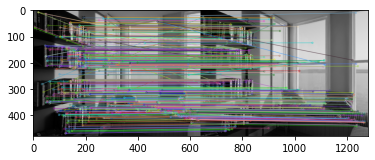

True

In [14]:
###Draw matches of salient features
img1 = cv.imread('Data/Frame1.tif',cv.IMREAD_GRAYSCALE)
img2 = cv.imread('Data/Frame2.tif',cv.IMREAD_GRAYSCALE)
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance: #default is 0.75
        good.append([m])
#draw matches
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()
cv.imwrite('two_compared.jpg',img3)

In [5]:
###Find and print fundamental matrix
img1 = cv.imread('Data/Frame1.tif',cv.IMREAD_GRAYSCALE)
img2 = cv.imread('Data/Frame2.tif',cv.IMREAD_GRAYSCALE)
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
pts1 = []
pts2 = []
for m,n in matches:
    if m.distance < 0.75*n.distance: #default is 0.75
        good.append([m])
        #store salient features coordinates
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
print(F)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

[[ 3.69842074e-07  2.80479875e-05 -8.81313330e-03]
 [-1.44397504e-05  2.32175973e-07 -8.18441166e-02]
 [ 5.49995702e-03  7.75042240e-02  1.00000000e+00]]


In [7]:
### function to draw epipolar lines
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

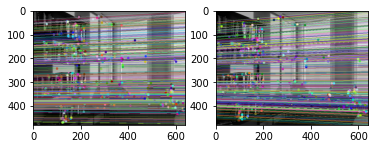

True

In [8]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()
cv.imwrite('epipolar_1.jpg',img5)
cv.imwrite('epipolar_2.jpg',img3)

In [9]:
### keep only epilines that fulfill the epipolar constraint with a threshold of below 0.1
temp_pts1 = pts1
temp_pts2 = pts2
good = []

for i in range(len(pts1)):
    if np.abs(np.transpose(np.append(pts1[i],1))@ F @ np.append(pts2[i],1)) < 0.1:
        good.append(i)

pts1 = pts1[good]
pts2 = pts2[good]

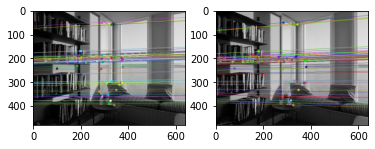

True

In [10]:
### Plot these new epilines
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()
cv.imwrite('epipolar_1_new.jpg',img5)
cv.imwrite('epipolar_2_new.jpg',img3)

In [11]:
### Camera parameters
k_1 = np.array([[497.77777778, 0., 319.5 ],
    [ 0., 497.77777778, 239.5 ],
    [0., 0., 1. ]], dtype=np.float64)
k_2 = k_1.copy()
distortion = np.array([0.0, 0.0, 0.0, 0.0, 0.0], dtype=np.float64)
r_vec = np.array([[9.96194713e-01, -5.41550256e-08, 8.71558063e-02],
                  [-1.60560472e-08, 1.00000012e+00, -5.68126794e-08],
                  [-8.71558795e-02, 1.94016203e-08, 9.96194765e-01]],dtype=np.float64)
t_vec = np.array([-2.48746482e-01, 1.28814475e-08, 1.27242718e-02],dtype=np.float64)
im_size = gray1.shape

In [12]:
###start rectifying images / get Q matrix to grab f and t
rotation1, rotation2, pose1, pose2, Q, roi1, roi2 = \
        cv.stereoRectify(cameraMatrix1=k_1,
                          distCoeffs1=distortion,
                          cameraMatrix2=k_2,
                          distCoeffs2=distortion,
                          imageSize=(im_size[1], im_size[0]),
                          R=r_vec,
                          T=t_vec,
                          flags=cv.CALIB_ZERO_DISPARITY,
                          alpha = 1.0
                          )
f = Q[2,3]
t = 1/Q[3,2]*(-1)
f_t = f*t
print('f={}'.format(f))
print('t={}'.format(t))
print('Q={}'.format(Q))

f=452.7433241273848
t=-0.2490717153757463
Q


array([[   1.        ,    0.        ,    0.        , -324.77698517],
       [   0.        ,    1.        ,    0.        , -239.5       ],
       [   0.        ,    0.        ,    0.        ,  452.74332413],
       [   0.        ,    0.        ,    4.01490791,   -0.        ]])

In [ ]:
### Rectify images and plot them side. by side
map1x, map1y = cv.initUndistortRectifyMap(k_1,distortion,rotation1, pose1, (im_size[1], im_size[0]), cv.CV_32FC1)
map2x, map2y = cv.initUndistortRectifyMap(k_2,distortion,rotation2, pose2, (im_size[1], im_size[0]), cv.CV_32FC1)
img_rect1 = cv.remap(gray1, map1x, map1y, cv.INTER_LINEAR)
img_rect2 = cv.remap(gray2, map2x, map2y, cv.INTER_LINEAR)
 
    # draw the images side by side
total_size = (max(img_rect1.shape[0], img_rect2.shape[0]), img_rect1.shape[1] + img_rect2.shape[1])
img = np.zeros(total_size, dtype=np.uint8)
img[:img_rect1.shape[0], :img_rect1.shape[1]] = img_rect1
img[:img_rect2.shape[0], img_rect1.shape[1]:] = img_rect2
 
# draw horizontal lines every 25 px accross the side by side image
for i in range(20, img.shape[0], 25):
    cv.line(img, (0, i), (img.shape[1], i), (255, 0, 0)) 

cv.imshow('imgRectified', img)
cv.waitKey()

In [13]:
print('Purple Difference')
disparity_1 = 61
disparity_2 = 38
depth_1 = f_t/disparity_1
depth_2 = f_t/disparity_2
difference = np.abs(depth_1 - depth_2)
print(difference)

Purple Difference
1.1188989630726836


In [14]:
print('Green Difference')
disparity_1 = 60
disparity_2 = 48
depth_1 = f_t/disparity_1
depth_2 = f_t/disparity_2
difference = np.abs(depth_1 - depth_2)
print(difference)

Green Difference
0.4698564848555218


In [15]:
print('Red Difference')
disparity_1 = 53
disparity_2 = 42
depth_1 = f_t/disparity_1
depth_2 = f_t/disparity_2
difference = np.abs(depth_1 - depth_2)
print(difference)

Red Difference
0.5572421922814814


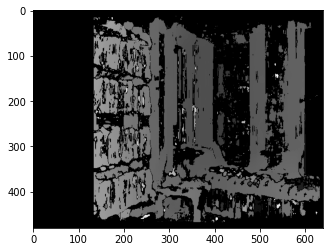

In [31]:
###Get disparity matrix
map1x, map1y = cv.initUndistortRectifyMap(k_1,distortion,rotation1, pose1, (im_size[1], im_size[0]), cv.CV_32FC1)
map2x, map2y = cv.initUndistortRectifyMap(k_2,distortion,rotation2, pose2, (im_size[1], im_size[0]), cv.CV_32FC1)
img_rect1 = cv.remap(gray1, map1x, map1y, cv.INTER_LINEAR)
img_rect2 = cv.remap(gray2, map2x, map2y, cv.INTER_LINEAR)
stereo = cv.StereoBM_create(numDisparities=128, blockSize=15)

disparity = stereo.compute(img_rect1, img_rect2)
plt.imshow(disparity,'gray')
plt.savefig('disparity_map')
plt.show()

In [ ]:
disparity[61, 259]